In [1]:
BASE_PROJECT_DIR = '/home/akhanal1/ature'
BASE_PROJECT_DIR = '/home/ak/PycharmProjects/ature'

import os
import sys
import traceback

sys.path.append(BASE_PROJECT_DIR)
os.chdir(BASE_PROJECT_DIR)

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
from utils import img_utils as iu
sep = os.sep
import torch
%load_ext autoreload
%autoreload 2

In [2]:
from PIL import Image as IMG
import utils.img_utils as iu
from commons.IMAGE import Image
import json

In [3]:
import torch
import torch.optim as optim
from neuralnet.unet.model import UNet
from neuralnet.unet.unet_dataloader import PatchesGenerator
from neuralnet.unet.unet_trainer import UNetNNTrainer
import torchvision.transforms as transforms
import neuralnet.utils.auto_split as asp
from neuralnet.utils.measurements import get_best_f1_thr

from neuralnet.unet.runs import DRIVE as unetDRIVE
from neuralnet.thrnet.runs import DRIVE32
from neuralnet.thrnet.runs import DRIVE16
from neuralnet.thrnet.runs import DRIVE32

122394


In [27]:
train_val = pd.read_csv(thrDRIVE['Dirs']['logs']+sep+'THRNET-DRIVE.chk.tar-TRAIN.csv', index_col='TYPE')
val = train_val.query('TYPE==1')
T_val = np.arange(val.shape[0])
train = train_val.query('TYPE==0')
T_train =np.arange(train.shape[0])
test= pd.read_csv(thrDRIVE['Dirs']['logs']+sep+'THRNET-DRIVE.chk.tar-TEST.csv', index_col='TYPE')
T_test = np.arange(test.shape[0])

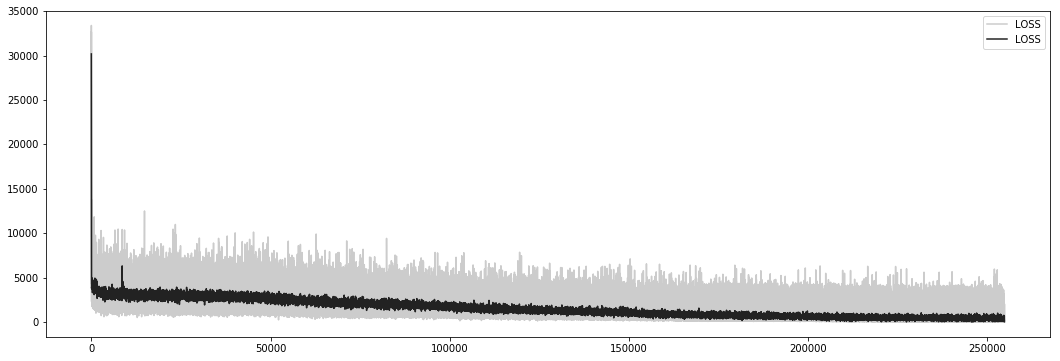

In [14]:
plt.rcParams["figure.figsize"] = [18,6]
fig, (ax1) = plt.subplots(nrows=1, ncols=1)
df = train.copy()
df['LOSS'] = savgol_filter(df['LOSS'], 51, 2)
plots = train.plot(y='LOSS', x=T_train, c='#cccccc', ax=ax1)
plots = df.plot(y='LOSS', x=T_train, c='#222222', ax=ax1)
plt.show()

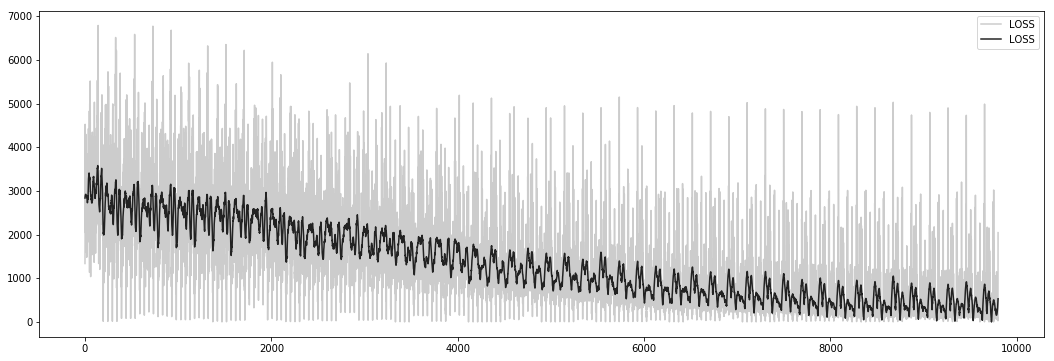

In [19]:
plt.rcParams["figure.figsize"] = [18,6]
fig, (ax1) = plt.subplots(nrows=1, ncols=1)
df = val.copy()
df['LOSS'] = savgol_filter(df['LOSS'], 51, 3)
plots = val.plot(y='LOSS', x=T_val, c='#cccccc', ax=ax1)
plots = df.plot(y='LOSS', x=T_val, c='#222222', ax=ax1)
plt.show()

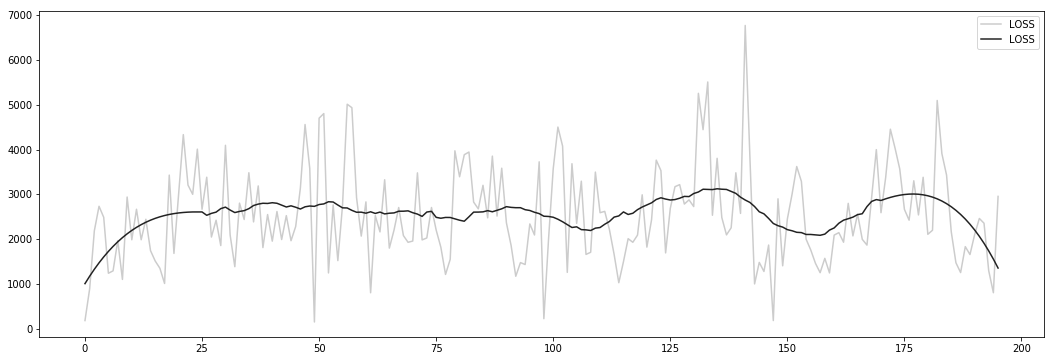

In [28]:
plt.rcParams["figure.figsize"] = [18,6]
fig, (ax1) = plt.subplots(nrows=1, ncols=1)
df = test.copy()
df['LOSS'] = savgol_filter(df['LOSS'], 51, 3)
plots = test.plot(y='LOSS', x=T_test, c='#cccccc', ax=ax1)
plots = df.plot(y='LOSS', x=T_test, c='#222222', ax=ax1)
plt.show()

### TEST Images

In [240]:
imap = Image()

In [388]:
file = '08_test.png'
imap.load_file(unetDRIVE['Dirs']['image'],  '08_test.tif')
imap.res['unet'] = iu.get_image_as_array(DRIVE16['Dirs']['image']+sep+file, channels=1)
# imap.res['thrnet'] = iu.get_image_as_array(DRIVE16['Dirs']['logs']+sep+file, channels=1)
imap.load_ground_truth(unetDRIVE['Dirs']['truth'], unetDRIVE['Funcs']['truth_getter'])
imap.load_mask(unetDRIVE['Dirs']['mask'], unetDRIVE['Funcs']['mask_getter'])

In [242]:
DRIVE32['Dirs']

{'image': 'data/DRIVE_UNET_MAP/images',
 'logs': 'data/DRIVE_UNET_MAP/thrnet32_logs',
 'mask': 'data/DRIVE/mask',
 'truth': 'data/DRIVE/manual'}

In [243]:
# ig = imap.res['thrnet'].copy()
# ig[imap.mask==0] = 0
# # iu.get_praf1(ig, imap.ground_truth)

In [11]:
# IMG.fromarray(imap.ground_truth)

### Find manual scores with threshodl for each batch

In [26]:
get_best_f1_thr(imap.res['unet'], imap.ground_truth)

({'Accuracy': 0.97975, 'F1': 0.87524, 'Precision': 0.89499, 'Recall': 0.85634},
 175.0)

In [430]:
j = imap.res['unet'].copy()
j[j>40] = 255
j[j<=50]=0
iu.get_praf1(j, imap.ground_truth)

{'Accuracy': 0.95312, 'F1': 0.76875, 'Precision': 0.66774, 'Recall': 0.90577}

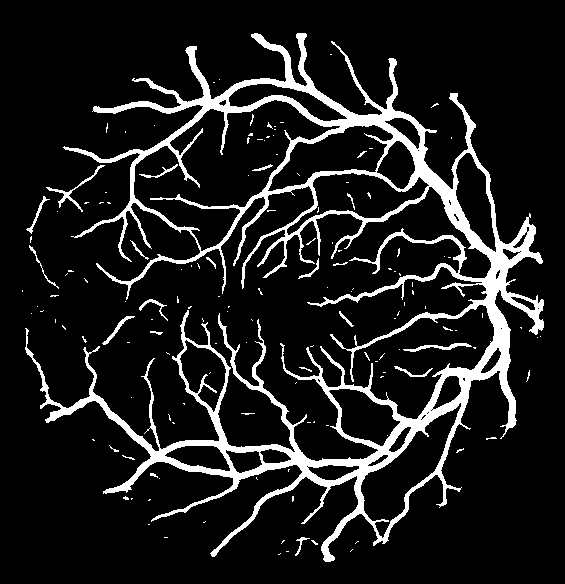

In [431]:
IMG.fromarray(j)

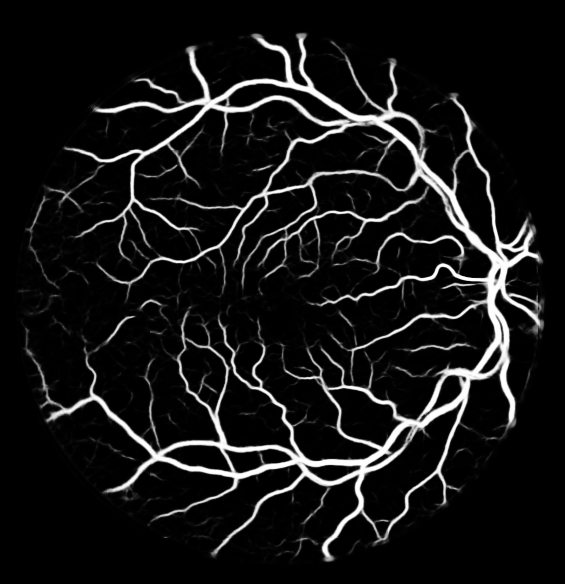

In [424]:
IMG.fromarray(imap.res['unet'])

In [391]:
from scipy.ndimage.measurements import label

In [432]:
myind = list(zip(*np.where(j == 255)))
myindes = list(iu.get_chunk_indices_by_index(imap.ground_truth.shape, (16,16), indices=myind[::10]))
len(myind)

38509

In [433]:
# IMG.fromarray(j[21:37, 301:317])
print(len(myindes))
my = np.zeros_like(j)
for p, q, r, s in myindes:
    my[p:q, r:s] = np.maximum(my[p:q, r:s], j[p:q, r:s])

3851


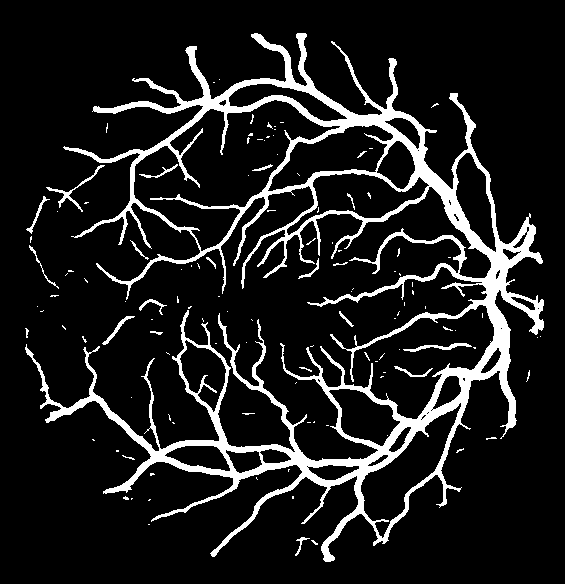

In [435]:
IMG.fromarray(my)

In [436]:
import math

In [437]:
structure = np.ones((3, 3), dtype=np.int)
labeled, ncomponents = label(j, structure)

In [438]:
for i in range(ncomponents):
    ixy = np.array(list(zip(*np.where(labeled == i))))
    x1, y1 = ixy[0]
    x2, y2 = ixy[-1]
    dst = math.sqrt((x2-x1)**2+(y2-y1)**2)
    if dst < 10:
        for u, v in ixy:
            j[u, v] = 0

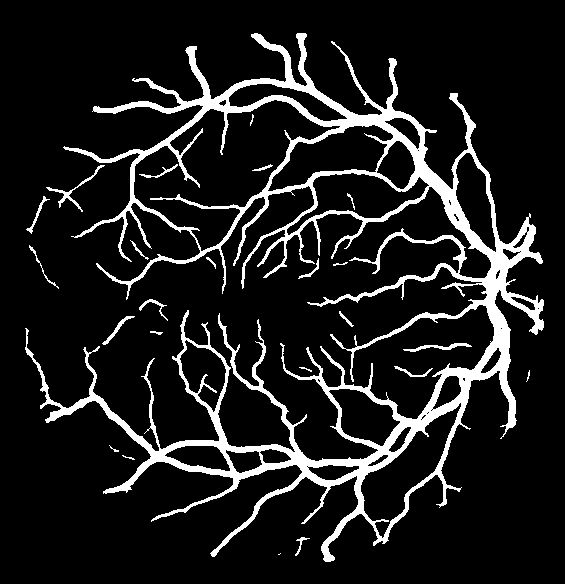

In [439]:
IMG.fromarray(j)

In [95]:
mm = np.zeros_like(imap.ground_truth)

In [209]:
z = []
for p, q, r, s in myindes:
    pp = j[p:q,r:s]
    ixx = list(zip(*np.where(pp == 255)))
    structure = np.ones((3, 3), dtype=np.int)
    labeled, ncomponents = label(pp, structure)
    print(ncomponents)
    x1,y1 = ixx[0]
    x2, y2 = ixx[-1]
    dst = math.sqrt((x2-x1)**2+(y2-y1)**2)
    if dst>7:
        z.append([pp])
        mm[p:q,r:s] = pp

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
2
1
1
1
1
2
1
1
1
2
2
1
1
1
1
2
2
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
2
1
1
1
1
1
2
1
1
1
1
2
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
2
1
1
2
1
1
3
1
1
2
1
1
2
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
2
1
1
1
1
1
1
2
2
1
1
1
1
2
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
2
1
1
1
2
1
2
1
1
1
2
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
2
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
2
1


In [188]:
import math
x1,y1 = ixx[0]
x2, y2 = ixx[-1]
math.sqrt((x2-x1)**2+(y2-y1)**2)

8.94427190999916

In [208]:
ncomponents

1

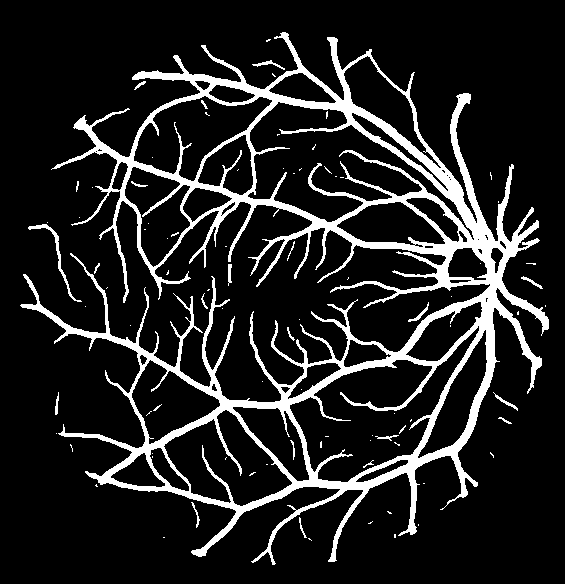

In [194]:
IMG.fromarray(mm)

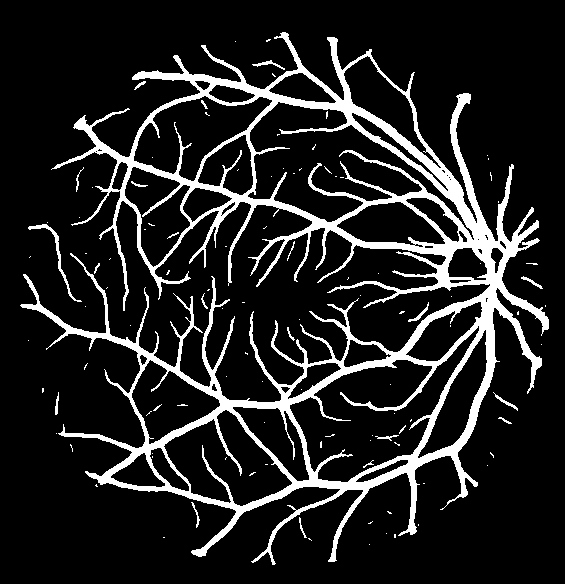

In [195]:
IMG.fromarray(j)

In [98]:
a = np.zeros((2,2))

In [99]:
b = np.zeros((5,5))

In [100]:
c = []

In [101]:
c.append(a)

In [103]:
c.append(b)

In [104]:
c.append(3)

In [182]:
(3,4)-(1,1)

TypeError: unsupported operand type(s) for -: 'tuple' and 'tuple'

In [106]:
def create_split_json(images_src_dir=None, ratio=[0.64, 0.18, 0.18], to_file='split.json'):
    if os.path.isfile(to_file):
        with open(to_file) as f:
            print('####SPLIT FOUND####: ', to_file + ' Loaded')
            return json.load(f)

    image_files = os.listdir(images_src_dir)
    n = len(image_files)
    configuration = {
        'train': image_files[0:int(round(ratio[0] * n))],
        'validation': image_files[0:int(round(ratio[1] * n))],
        'test': image_files[0:int(round(ratio[2] * n))]
    }

    f = open(to_file, "w")
    f.write(json.dumps(configuration))
    f.close()
    return configuration

In [118]:
files = os.listdir('.')

In [125]:
sp=create_split_json('.', to_file='f.json')

In [124]:
len(files)

16

In [126]:
len(sp['train'])

10

In [127]:
len(sp['test'])

3

In [128]:
len(sp['validation'])

3

In [117]:
os.listdir('.')

['split.json',
 'commons',
 'notebook',
 'assests',
 'net_logs',
 '1.png',
 'README.md',
 'utils',
 'data',
 'neuralnet',
 'testing',
 '.idea',
 '2.png',
 '.git',
 '.gitignore',
 'data_access.py']

In [129]:
sp

{'test': ['split.json', 'commons', 'notebook'],
 'train': ['split.json',
  'commons',
  'notebook',
  'assests',
  'net_logs',
  '1.png',
  'README.md',
  'utils',
  'data',
  'neuralnet'],
 'validation': ['split.json', 'commons', 'notebook']}

In [144]:
a = np.arange(0, 15)

In [145]:
n=a.shape[0]
a[0:int(0.5*n)]

array([0, 1, 2, 3, 4, 5, 6])

In [139]:
a

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [146]:
a[int(0.5*n):int(0.25*n)]

array([], dtype=int64)

In [156]:
round(0.2* 14)

3

In [171]:
a[12:14]

array([12, 13])

In [164]:
a[11:-1] i = int(round(ratio[0]*n))
    j = i+int(round(ratio[1]*n))
    k = j+int(round(ratio[2]*n))

array([11, 12, 13])

In [169]:
n=14
i = int(round(0.6*n))
j = i+int(round(0.2*n))
k = j+int(round(0.2*n))

In [170]:
i,j,k

(8, 11, 14)

In [168]:
n

15